# PLAの性能保証：理論と現実

演習課題の内容は、`PLA_bounds-JA.pdf`を参照すること。

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import data_perceptron_generic
import algo_PLA
import algo_PLA_pocket
import model_perceptron

_fontsize = "xx-large"

## 過剰期待損失の分布

### 汎化誤差の上界を用いる

複雑度に基づく期待損失の上界を思い出すと、学習アルゴリズムを実行した結果として得られる$\,\widehat{h}\in \mathcal{H}\,$に対して、$\,(1-\delta)\,$以上の確率で、下記が成り立つ。

\begin{align*}
R(\widehat{h}) - \widehat{R}(\widehat{h}) \leq + \sqrt{\frac{8}{n}\log\left(\frac{4((2n)^{d_{\text{VC}}(\mathcal{H})}+1)}{\delta}\right)}
\end{align*}

ここで$\,d_{\text{VC}}(\mathcal{H})\,$はモデル$\,\mathcal{H}\,$のVC次元である。

また、この左辺を「__過剰リスク__」もしくは「__過剰期待損失__」と呼ぶ。英語でexcess riskという。

### パーセプトロンの過剰リスク

線形パーセプトロンの場合を考えると以下のようになる。

\begin{align*}
\mathcal{H} = \left\{h: h(\mathbf{x}) = \text{sign}\left(\mathbf{w}^{T}\mathbf{x}-w_{0}\right)\right\}
\end{align*}

このとき、VC次元が以下のようになることが知られている。

\begin{align*}
d_{\text{VC}}(\mathcal{H}) = d+1
\end{align*}

この$\,d\,$とは、入力ベクトル$\,\mathbf{x}\,$の次元である。

この上界を計算するための関数`err_gen_VC_perceptron`を以下のように定義する。

In [2]:
def err_gen_VC_perceptron(n, d, delta):
    d_vc = d+1
    n_factor = 8 / n
    log_factor = math.log(4)+d_vc*math.log(2*n)+1-math.log(delta)
    return np.sqrt(n_factor*log_factor)

#### 関数の補足説明

数値計算の問題として、$\log$に入る数量が相当大きくなりうる。オーバーフロー対策として、簡単な上界による近似を用いることにする。まず、$x > 0$に対して$\log(x)$の一階微分が$1/x$であるため、対数関数の勾配が、$x \geq 1$の範囲において、$1$以下であることがわかる。このLipschitz連続性を利用すると、

\begin{align*}
\left|\log(1+x) - \log(x)\right| \leq 1, \text{ for all } x \geq 1
\end{align*}

つまり、

\begin{align*}
\log(1+x) \leq \log(x)+1
\end{align*}

という上界を、$x \geq 1$のときに使うことができる。元の汎化誤差の話に戻ると、ログの部分を次のように近似できる。

\begin{align*}
\log\left( \frac{4((2n)^{d_{\text{VC}}}+1)}{\delta} \right) & = \log(4) + \log\left((2n)^{d_{\text{VC}}}+1\right) - \log(\delta)\\
& \leq \log(4) +  d_{\text{VC}}\log\left(2n\right) + 1 - \log(\delta).
\end{align*}

上記の計算方法を、`err_gen_VC_perceptron`のなかで利用している。

#### PLAを走らせて過剰リスク分布を見る

以下のコードブロックでは、次のような操作をしている。

- 複数の試行にわたって、データを独立に生成し、PLAをひと通り走らせ、標本内外の識別率を記録している。

- 過剰リスクを近似的に計算し、その分布をヒストグラムで可視化している。

- さらに、過剰リスクの分布に基づいて、その$\,(1-\delta)\,$の分位値を計算し、ヒストグラムとともに表示している。

- さらに、パーセプトロンモデルのVC次元に基づく過剰リスクの上界を計算し、ヒストグラムとともに表示している。

- 最後に、過剰リスクではなく、リスク自体、つまり期待損失そのものの分布をヒストグラムで可視化し、その$\,(1-\delta)\,$の分位値も併せて表示している。


In [3]:
_n_tr = 500
_n_te = _n_tr * 100
_d = 2
_delta = 0.1
_num_trials = 5000
_t_max = 25

In [4]:
err_gen = err_gen_VC_perceptron(n=_n_tr, d=_d, delta=_delta)

perf = np.zeros((_num_trials,2), dtype=np.float32)

for tri in range(_num_trials):
    
    data = data_perceptron_generic.gen(n_tr=_n_tr, n_te=_n_te, d=_d)
    
    w_init = np.random.uniform(low=-0.05, high=0.05, size=(data.d_tr,1))
    
    algo = algo_PLA.PLA(w_init=w_init, t_max=_t_max)
    model = model_perceptron.Perceptron()
    
    for onestep in algo:
        algo.update(model=model, data=data)
        
    perf[tri,0] = np.mean(model.l_tr(w=algo.w, data=data))
    perf[tri,1] = np.mean(model.l_te(w=algo.w, data=data))
    

In [5]:
risk = perf[:,1]
emp_risk = perf[:,0]
excess_risk = risk-emp_risk

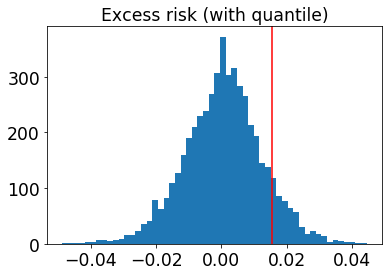

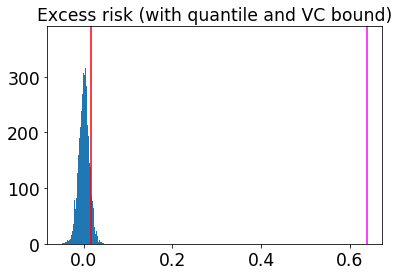

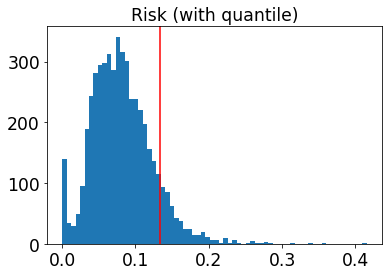

In [6]:
plt.hist(excess_risk, bins='auto')
plt.axvline(x=np.percentile(a=excess_risk, q=100*(1-_delta)),
            color="red")
plt.title("Excess risk (with quantile)", size=_fontsize)
plt.tick_params(labelsize=_fontsize)
plt.show()

plt.hist(excess_risk, bins='auto')
plt.axvline(x=np.percentile(a=excess_risk, q=100*(1-_delta)),
            color="red")
plt.axvline(x=err_gen, color="magenta")
plt.title("Excess risk (with quantile and VC bound)", size=_fontsize)
plt.tick_params(labelsize=_fontsize)
plt.show()

plt.hist(risk, bins='auto')
plt.axvline(x=np.percentile(a=risk, q=100*(1-_delta)),
            color="red")
plt.title("Risk (with quantile)", size=_fontsize)
plt.tick_params(labelsize=_fontsize)
plt.show()

___

## 過剰リスクの裾の上界

まず、先ほどの期待損失の上界から、下記を直接導き出すことができる。

\begin{align*}
\mathbf{P}\left\{R(\widehat{h}) - \widehat{R}(\widehat{h}) > \epsilon\right\} \leq 4\left((2n)^{d_{\text{VC}}(\mathcal{H})}+1\right)\exp\left(-\frac{\epsilon^{2}n}{8}\right).
\end{align*}

これを実装した関数は下記の通りである。

In [7]:
def tail_gen_VC_perceptron(n, d, epsilon):
    d_vc = d+1
    return 4*((2*n)**d_vc+1) * np.exp(-(n*epsilon**2)/8)

In [8]:
epsilon_vals =  np.linspace(start=0.01, stop=0.3, num=500)

vc_vals = tail_gen_VC_perceptron(n=_n_tr, d=_d, epsilon=epsilon_vals)

perf_tail = np.zeros((epsilon_vals.size,), dtype=np.float32)

for i in range(epsilon_vals.size):
    
    epsilon = epsilon_vals[i]
    
    check_tail = perf[:,1]-perf[:,0] > epsilon
    
    perf_tail[i] = np.sum(check_tail) / check_tail.size


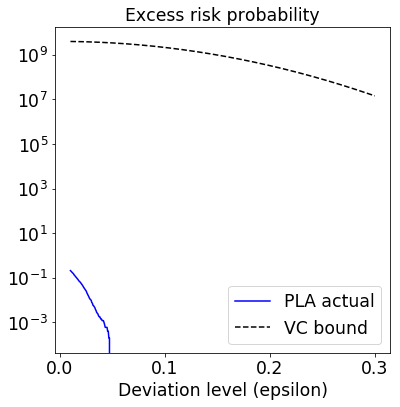

In [9]:
myfig = plt.figure(figsize=(6,6))

ax = myfig.add_subplot(1,1,1)
plt.title("Excess risk probability", size=_fontsize)
ax.semilogy(epsilon_vals, perf_tail, "-", color="blue", label="PLA actual")
ax.semilogy(epsilon_vals, vc_vals, "--", color="black", label="VC bound")
ax.legend(loc="best",ncol=1, fontsize=_fontsize)
plt.xlabel("Deviation level (epsilon)", size=_fontsize)
ax.tick_params(labelsize=_fontsize)

plt.show()

## 標本複雑度の上界

汎化誤差を$\epsilon$以下に抑えるには、以下を満たせば十分である。

\begin{align*}
n \geq \frac{8}{\epsilon^{2}}\log\left( \frac{4((2n)^{d_{\text{VC}}}+1)}{\delta} \right)
\end{align*}

この下界を実装したのが下記の`sample_VC_perceptron`である。

In [10]:
def sample_VC_perceptron(n, d, delta, epsilon):
    d_vc = d+1
    eps_factor = 8 / epsilon**2
    log_factor = math.log(4)+d_vc*math.log(2*n)+1-math.log(delta)
    return eps_factor*log_factor

上記の標本複雑度の上界は、$\,n\,$に対して陰である。幸い、不動点を使って、反復的に計算することが簡単にできる。この不等式の右辺を$\,f(n)\,$と書くと、以下の演算、

\begin{align*}
n_{(t+1)} \gets f(n_{(t)})
\end{align*}

を繰り返して行うと、関数（＝下界）の不動点の良い近似を得ることができる。この不動点をたとえば$\,n_{\text{fix}}\,$と書くことにする。定義上、$\,f(n_{\text{fix}})=n_{\text{fix}}\,$が成り立つので、どの$\,n \geq n_{\text{fix}}\,$を取っても、単調性により$\,n \geq f(n)\,$を満たすことになる。

下界を反復的に計算してみる。収束が速いことは一目瞭然である。

In [11]:
_n0 = 500
_delta = 0.1
_epsilon = 0.1
_d = 3

In [12]:
ncheck = _n0
for i in range(10):
    print("ncheck =", ncheck)
    ncheck = sample_VC_perceptron(n=ncheck, d=_d,
                                  delta=_delta, epsilon=_epsilon)

ncheck = 500
ncheck = 25855.920456033986
ncheck = 38482.1181727442
ncheck = 39754.61117895145
ncheck = 39858.71411822344
ncheck = 39867.0828076179
ncheck = 39867.75460538458
ncheck = 39867.80852793395
ncheck = 39867.8128560443
ncheck = 39867.813203441176


続いて、この値が$d_{\text{VC}}$の増加によってどう変わるか調べる。

In [13]:
d_vals = np.arange(2, 30, 1)
n_vals = []
for d_val in d_vals:
    n_check = _n0
    for i in range(50):
        n_check = sample_VC_perceptron(n=n_check, d=d_val,
                                       delta=0.1, epsilon=0.1)
    n_vals += [n_check]
n_vals = np.array(n_vals)

In [14]:
print("Ratio of sample complexity to d_vc:")
print(n_vals/(d_vals+1))

Ratio of sample complexity to d_vc:
[10056.55976023  9966.95330844  9957.12359783  9979.76076512
 10016.7271532  10060.01833628 10105.77668152 10152.0401463
 10197.78395024 10242.47378812 10285.84264061 10327.77315122
 10368.23298839 10407.23815017 10444.83161248 10481.07068714
 10516.01946022 10549.74425972 10582.31096093 10613.78342108
 10644.22261354 10673.68619661 10702.22835162 10729.89978558
 10756.74783243 10782.81661013 10808.14720696 10832.77787978]


上記の簡単な計算結果を踏まえて、理論の上では、$n \approx 10000\,d_{\text{VC}}$があれば、汎化能力は保証できる($\epsilon = 0.1,\delta=0.1$のとき)。しかし、この計算の元となる上界が緩いことはすでに見ているので、実際には、より少ない標本数でも大丈夫であろうと期待するところである。

以下の実験で、実際にどの程度のデータがあれば良いか調べてみる。

In [15]:
_k_factors = np.array([1, 10, 100, 1000, 10000])
_n_te = 50000
_num_trials = 500
_t_max = 20

In [16]:
perf_quantiles = np.zeros((_k_factors.size,), dtype=np.float32)

for i in range(_k_factors.size):
    
    print("Working on k =", _k_factors[i])
    
    n_tr = _k_factors[i] * (_d+1)
    
    perf = np.zeros((_num_trials,2), dtype=np.float32)

    for tri in range(_num_trials):
        
        data = data_perceptron_generic.gen(n_tr=n_tr, n_te=_n_te, d=_d)
        
        w_init = np.random.uniform(low=-0.05, high=0.05, size=(data.d_tr,1))
        
        algo = algo_PLA.PLA(w_init=w_init, t_max=_t_max)
        model = model_perceptron.Perceptron()
    
        for onestep in algo:
            algo.update(model=model, data=data)
        
        perf[tri,0] = np.mean(model.l_tr(w=algo.w, data=data))
        perf[tri,1] = np.mean(model.l_te(w=algo.w, data=data))
    
    perf_quantiles[i] = np.percentile(a=(perf[:,1]-perf[:,0]),
                                      q=(100*(1-_delta)))

Working on k = 1
Working on k = 10
Working on k = 100
Working on k = 1000
Working on k = 10000


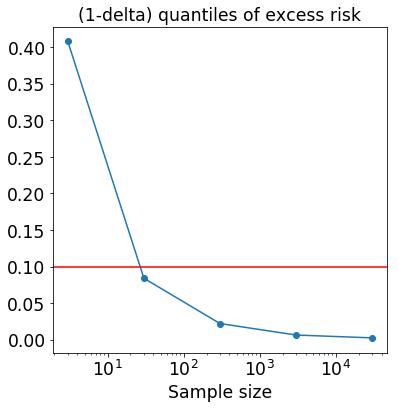

In [17]:
myfig = plt.figure(figsize=(6,6))

ax = myfig.add_subplot(1,1,1)
plt.title("(1-delta) quantiles of excess risk", size=_fontsize)
ax.semilogx(_d*_k_factors, perf_quantiles, marker="o")
plt.axhline(y=_epsilon, color="red")
plt.xlabel("Sample size", size=_fontsize)
ax.tick_params(labelsize=_fontsize)

plt.show()

この数値実験の結果は明白である。理論が担保するように、たとえば$n \approx 10^{4}\,d_{\text{VC}}$を取れば、$90\%$の確率で誤差$\epsilon=0.1$という汎化能力は確かに保証できるのだが、これは必要以上である。実際、$n \approx 10\,d_{\text{VC}}$があれば十分という実験結果である。

___